In [25]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import hvplot.pandas

In [26]:
from os import listdir
from os.path import isfile

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
dir = "../Resources/"

In [29]:
# Read all the files from the resources and put them in a list
all_files = [x for x in listdir(dir) if (".xlsx" in x or ".csv" in x)]
all_files

['corn.xlsx',
 'feeder_cattle.xlsx',
 'live_cattle.xlsx',
 'soybean_meal.xlsx',
 'lean_hogs.xlsx']

In [30]:
all_df = pd.DataFrame()
for x in all_files:
    a = x.replace(".xlsx", "")
    df = pd.read_excel(dir+x)
    df["name"] = a
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")
    df = df.sort_index()
    df = df.dropna()
    df = df[df['Volume'] != 0.0]
    df.drop(['Volume'], axis=1, inplace=True)
    if a == "corn":
        corn = df
        all_df["corn"] = corn["Price"]
    elif a == "live_cattle":
        live_cattle = df
        all_df["live_cattle"] = live_cattle["Price"]
    elif a == "feeder_cattle":
        feeder_cattle = df
        all_df["feeder_cattle"] = feeder_cattle["Price"]
    elif a == "soybean_meal":
        soybean = df
        all_df["soybean"] = soybean["Price"]
    elif a == "lean_hogs":
        hog = df
        all_df["hog"] = hog["Price"]

In [31]:
all_df['hog_delta_5'] = all_df["hog"].shift(152)
all_df['corn_delta_5'] = all_df["corn"].shift(152)
all_df['soybean_delta_5'] = all_df["soybean"].shift(152)
all_df = all_df.dropna()
# Crush Margin = 2 x CME lean hog futures price (5 months
# from placement) – 0.5 x CME lean hog futures price (5
# months from placement) – 10 x CME corn futures price (at
# placement) – 0.075 x CME soybean meal futures price (at
# placement)
# GFM t= 2.05 * LH t - WP t-5-(10 * C t-5)-(0.075 * SM t-5)
all_df["GFM"] = (2.05*all_df["hog"]) - (all_df['hog_delta_5']*0.5) - (10 * all_df['corn_delta_5']) - (0.075 * all_df['soybean_delta_5'])
all_df = all_df.drop(columns=['feeder_cattle', 'live_cattle', 'hog_delta_5', 'corn_delta_5', 'soybean_delta_5'])
all_df.head(10)

,corn,soybean,hog,GFM
Date,,,,
2001-08-10,2.3425,167.3,56.550,52.78000
2001-08-13,2.3700,169.7,56.875,53.63875
2001-08-15,2.3175,169.5,56.500,53.01000
2001-08-16,2.2950,166.1,56.325,52.33125
2001-08-17,2.2825,166.4,56.375,52.89125
2001-08-20,2.2500,163.4,56.050,52.03000
2001-08-21,2.2775,165.1,54.050,47.67500
2001-08-22,2.2800,164.4,54.550,48.81000
2001-08-23,2.3175,162.9,54.850,50.13000


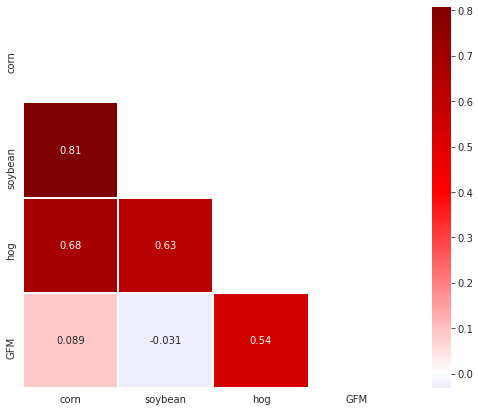

In [32]:
all_df = all_df.dropna()
corrM = all_df.corr()

mask = np.zeros_like(corrM)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10,7))
    ax = sns.heatmap(corrM, mask=mask, center=0, annot=True, square=True, linewidths=1, cmap="seismic")

In [33]:
all_df.hvplot.line(xlabel="Time", ylabel="Price")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [34]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [35]:
window_size = 10


feature_column = 3
target_column = 2
X, y = window_data(all_df, window_size, feature_column, target_column)

In [36]:
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [37]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()

scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [38]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [40]:
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape = (X_train.shape[1],1))
         )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True,
        ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units,
    return_sequences = False,
        ))
model.add(Dropout(dropout_fraction))

model.add(Dense(1))

In [41]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 30)            3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [43]:
epochs = 15
batch_size = 10
model.fit(X_train, y_train, epochs=epochs, shuffle=False, batch_size=batch_size, verbose=1)

Epoch 1/15
314/314 [==============================] - 15s 23ms/step - loss: 0.0113
Epoch 2/15
314/314 [==============================] - 8s 25ms/step - loss: 0.0104
Epoch 3/15
314/314 [==============================] - 8s 25ms/step - loss: 0.0110
Epoch 4/15
314/314 [==============================] - 9s 30ms/step - loss: 0.0113
Epoch 5/15
314/314 [==============================] - 11s 36ms/step - loss: 0.0115
Epoch 6/15
314/314 [==============================] - 15s 47ms/step - loss: 0.0117
Epoch 7/15
314/314 [==============================] - 22s 69ms/step - loss: 0.0116
Epoch 8/15
314/314 [==============================] - 19s 60ms/step - loss: 0.0121
Epoch 9/15
314/314 [==============================] - 13s 40ms/step - loss: 0.0118
Epoch 10/15
314/314 [==============================] - 10s 32ms/step - loss: 0.0120
Epoch 11/15
314/314 [==============================] - 10s 31ms/step - loss: 0.0123
Epoch 12/15
314/314 [==============================] - 11s 34ms/step - loss: 0.0119
Epoc

In [44]:
model.evaluate(X_test, y_test)

43/43 [==============================] - 3s 9ms/step - loss: 0.0069


0.006880787666887045

In [45]:
predicted = model.predict(X_test)

In [46]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [47]:
hogs = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
hogs.head()

,Real,Predicted
Date,,
2016-07-06,64.175,65.640747
2016-07-07,63.125,65.629662
2016-07-08,63.925,65.663742
2016-07-11,63.700,65.715698
2016-07-12,63.325,65.745201


In [48]:
hogs.hvplot.line(xlabel="Date", ylabel="Price")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)